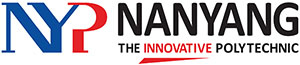

# IT3386 - AI Services in Analytics

## Part 2 - AutoML in Vertex AI

This template contains some steps to help you complete your assignment. Refer to the assignment brief for details on the tasks you are required to perform and add them into the notebook accordingly.

READ ALL INSTRUCTIONS CAREFULLY

### Setup

In [1]:
# add service key json into env
%env GOOGLE_APPLICATION_CREDENTIALS=key_i220342h.json
%env GOOGLE_APPLICATION_CREDENTIALS

env: GOOGLE_APPLICATION_CREDENTIALS=key_i220342h.json


'key_i220342h.json'

In [2]:
# settings
PROJECT_ID = "i220342h"
BUCKET_NAME = PROJECT_ID + "-3386-aip"
BUCKET_URI = f"gs://{BUCKET_NAME}"
REGION = "us-central1"
print(BUCKET_URI)

gs://i220342h-3386-aip


In [3]:
# full path of annotation file, which you have checked in Part 1 during data preparation
IMPORT_FILE = f"{BUCKET_URI}/train/annotations.csv"
print(IMPORT_FILE)

gs://i220342h-3386-aip/train/annotations.csv


### Initialize SDK

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
!pip install google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00


In [6]:
import google.cloud.aiplatform as aip

aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

### Create the Dataset

Next, create the `Dataset` resource using the `create` method for the `ImageDataset` class, which takes the following parameters:

- `display_name`: The human readable name for the `Dataset` resource.
- `gcs_source`: A list of one or more dataset index files to import the data items into the `Dataset` resource.
- `import_schema_uri`: The data labeling schema for the data items.

Depending on the number of images you have, this operation may take 10 to 30 minutes.

Increase the polling duration from 900s to 3600s to prevent timeout when creating your dataset in Vertex AI.

In [7]:
from google.api_core.future.polling import DEFAULT_POLLING

print(DEFAULT_POLLING)
### Set the default timeout to an hour
DEFAULT_POLLING._timeout = 3600

print(DEFAULT_POLLING)

<Retry predicate=<function if_exception_type.<locals>.if_exception_type_predicate at 0x1146ef9c0>, initial=1.0, maximum=20.0, multiplier=1.5, timeout=900, on_error=None>
<Retry predicate=<function if_exception_type.<locals>.if_exception_type_predicate at 0x1146ef9c0>, initial=1.0, maximum=20.0, multiplier=1.5, timeout=3600, on_error=None>


Choose a display name for your model. This will be reflected in the Google console.

In [8]:
# e.g. display_name = 'masks'
display_name = "Workplace_Safety_CV"

In [9]:
# send a request to server to create a dataset for object detection by importing images from your bucket to Vertex AI platform
# once this cell executes, the server will try to create your dataset; even if your kernel dies in the process,
# the server will continue running until it completes creating the dataset
# hence if you kernel dies in the process, you need not run this cell again; see next cell

# aip already has project id and bucket name from aip.init()
dataset = aip.ImageDataset.create(
    display_name=display_name,
    gcs_source=[IMPORT_FILE],
    import_schema_uri=aip.schema.dataset.ioformat.image.bounding_box,
)

print(dataset.resource_name)

Creating ImageDataset
Create ImageDataset backing LRO: projects/689154225179/locations/us-central1/datasets/8922805689995231232/operations/1214539682415640576
ImageDataset created. Resource name: projects/689154225179/locations/us-central1/datasets/8922805689995231232
To use this ImageDataset in another session:
ds = aiplatform.ImageDataset('projects/689154225179/locations/us-central1/datasets/8922805689995231232')
Importing ImageDataset data: projects/689154225179/locations/us-central1/datasets/8922805689995231232
Import ImageDataset data backing LRO: projects/689154225179/locations/us-central1/datasets/8922805689995231232/operations/1944122822049660928
ImageDataset data imported. Resource name: projects/689154225179/locations/us-central1/datasets/8922805689995231232
projects/689154225179/locations/us-central1/datasets/8922805689995231232


In [ ]:
# if kernel died, run this cell to get a reference to your dataset; if dataset is empty, it means the server is still working
# on it; wait a while and run again
# 
# dataset = aip.ImageDataset.list()[0]
# dataset

In [10]:
dataset

resource name: projects/689154225179/locations/us-central1/datasets/8922805689995231232

*Sample output:* 
```
<google.cloud.aiplatform.datasets.image_dataset.ImageDataset object at 0x000002C0965245B0> 
resource name: projects/122765136922/locations/us-central1/datasets/1217403463529398272
```

### Training

To train an AutoML model, you need to perform two steps: 
1. Create a training pipeline
2. Run the pipeline (i.e. actual training, estimated 1 - 2 hours)

<span style="color:red"><b>&#9888; IMPORTANT</b></span>

You are encouraged to leave your local terminal running so that the cell can run to completion. 


<span style="color:red">You have <u>ONE</u> attempt to train your model so verify all settings and data before you continue. You will be penalised under Resource Management if you need to retrain your model. Contact your tutor immediately before you retrain your model.</span>


**Create training pipeline**

Reference: [AutoMLImageTrainingJob](https://cloud.google.com/python/docs/reference/aiplatform/1.9.0/google.cloud.aiplatform.AutoMLImageTrainingJob)

An AutoML training pipeline is created with the `AutoMLImageTrainingJob` class, with the following parameters:

- `display_name`: The human readable name for the `TrainingJob` resource.
- `prediction_type`: The type task to train the model for.
  - `object_detection`: An image object detection model.
- `multi_label`: If a classification task, whether single (`False`) or multi-labeled (`True`).
- `model_type`: The type of model for deployment.
  - `CLOUD_LOW_LATENCY_`: Optimized for latency over accuracy for deployment on Google Cloud.
- `base_model`: (optional) Transfer learning from existing `Model` resource -- supported for image classification only.

The instantiated object is the DAG (directed acyclic graph) for the training job.

In [11]:
# use the following parameters; do not change
dag = aip.AutoMLImageTrainingJob(
    display_name=display_name,
    prediction_type="object_detection",
    multi_label=False,
    model_type="CLOUD_LOW_LATENCY_1",
    base_model=None,
)

print(dag)

#### Run the training pipeline

Next, you run the DAG to start the training job by invoking the method `run`, with the following parameters:

- `dataset`: The `Dataset` resource to train the model.
- `model_display_name`: The human readable name for the trained model.
- `training_fraction_split`: The percentage of the dataset to use for training.
- `test_fraction_split`: The percentage of the dataset to use for test (holdout data).
- `validation_fraction_split`: The percentage of the dataset to use for validation.
- `budget_milli_node_hours`: Maximum training time specified in unit of millihours (1000 = hour).
- `disable_early_stopping`: If `True`, training maybe completed before using the entire budget if the service believes it cannot further improve on the model objective measurements.

The `run` method returns the `Model` resource when completed.

<span style="color:red">&#9888; Once the cell below executes without error, training will start at the server and you will receive periodic status that the pipeline is running. If the display hangs or your laptop reboots or your kernel dies, etc., do not run the cell again. Proceed to next section - Evaluation.</span>

In [12]:
# use the following parameters; do not change 
# it takes about 1 to 2 hours to complete this cell
model = dag.run(
    dataset=dataset,
    model_display_name=display_name,
    training_fraction_split=0.8,
    validation_fraction_split=0.1,
    test_fraction_split=0.1,
    budget_milli_node_hours=20000,
    disable_early_stopping=False,
)


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5032669470011686912?project=689154225179
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
2
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTrainingJob projects/689154225179/locations/us-central1/trainingPipelines/5032669470011686912 current state:
3
AutoMLImageTra

### Evaluation

Reference: [Evaluate AutoML image object detection models](https://cloud.google.com/vertex-ai/docs/image-data/object-detection/evaluate-model)

**Review model evaluation score**

After your model has finished training, you can review the evaluation scores for it.

First, you need to get a reference to the new model. As with datasets, you can either use the reference to the model variable you created when you deployed the model or you can list all of the models in your project.

<span style="color:red">You should only have one model that completed training. If you have more than one trained model, you will be penalised under resource management.</span>

In [33]:
# your model will appear after training is completed
# if you arrive here because your kernel died during training, keep running this cell until you see your model appears
aip.Model.list()

 resource name: projects/689154225179/locations/us-central1/models/8350119011354148864]

*Example output:*
```
[<google.cloud.aiplatform.models.Model object at 0x000002C0985F56A0> 
 resource name: projects/122765136922/locations/us-central1/models/6037367770583138304]
```

In [34]:
# Get model resource ID
models = aip.Model.list()

# Get a reference to the Model Service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
model_service_client = aip.gapic.ModelServiceClient(client_options=client_options)

model_evaluations = model_service_client.list_model_evaluations(
    parent=models[0].resource_name
)
model_evaluation = list(model_evaluations)[0]
print(model_evaluation)

name: "projects/689154225179/locations/us-central1/models/8350119011354148864@1/evaluations/4619848870061408256"
metrics_schema_uri: "gs://google-cloud-aiplatform/schema/modelevaluation/image_object_detection_metrics_1.0.0.yaml"
metrics {
  struct_value {
    fields {
      key: "boundingBoxMeanAveragePrecision"
      value {
        number_value: 0.7478193
      }
    }
    fields {
      key: "boundingBoxMetrics"
      value {
        list_value {
          values {
            struct_value {
              fields {
                key: "confidenceMetrics"
                value {
                  list_value {
                    values {
                      struct_value {
                        fields {
                          key: "confidenceThreshold"
                          value {
                            number_value: 0.031644154
                          }
                        }
                        fields {
                          key: "f1Score"
             

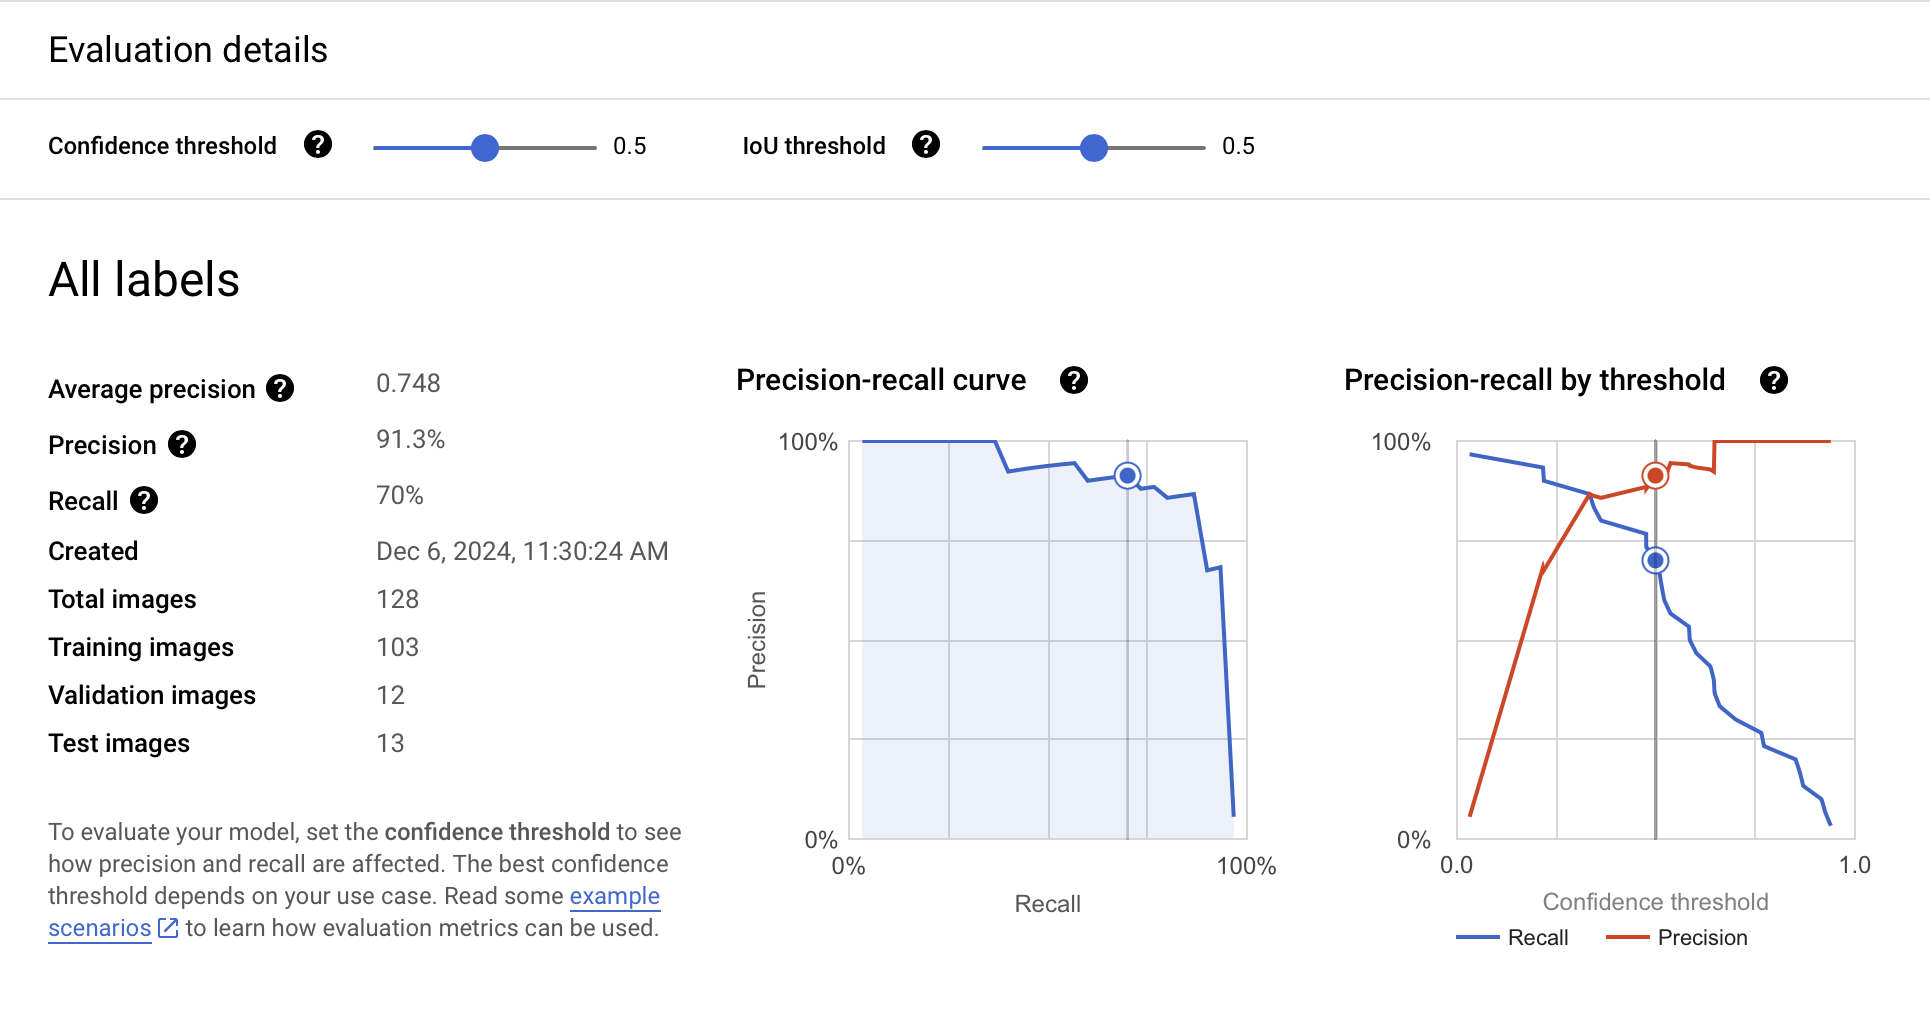
## Precision and Recall
Precision and recall are fundamental metrics that shape our understanding of the model's performance. 

Precision measures the accuracy of positive predictions - in our case, the model achieves 100% precision for ladder detection and 83.3% for person detection, meaning every ladder identification is correct while person detection occasionally produces false positives. 

Recall, measuring the model's ability to find all relevant instances, shows 71.4% for ladders and 62.5% for people, indicating that the model misses some instances of both classes but is better at finding ladders than people.

## Intersection over Union (IoU)
IoU measures how well our predicted bounding boxes overlap with the ground truth annotations. With our current IoU threshold at 0.5, a prediction must overlap at least 50% with the actual object to be considered correct. 
 
This threshold affects both precision and recall: a higher IoU demands more accurate box placement, while a lower IoU accepts looser bounds but risks counting imprecise detections as correct.

## Real-world practice
In real-world practice, these results suggest our model is particularly reliable for ladder detection but more cautious about person detection. This behavior could be beneficial in safety monitoring applications where false alarms about ladder misuse could be costly or disruptive. 

However, the lower recall rates indicate that some instances of both ladders and people are missed, which could be concerning in safety-critical applications.

## What happens when we tune the confidence threshold?
Currently set at 0.5, increasing this threshold would make the model more selective, potentially improving precision by only reporting high-confidence detections. This might be appropriate in situations where false alarms are costly or disruptive. 

Conversely, decreasing the threshold would capture more potential instances but at the risk of false positives. In safety applications, a lower threshold might be preferred to err on the side of caution, ensuring fewer missed incidents despite occasional false alarms

## What happens when we tune the IoU threshold?
Increasing the IoU threshold would demand more precise object localization, which might be crucial in applications requiring exact positioning information, such as analyzing ladder placement angles or worker positioning. However, it can dramatically reduce the model's recall by rejecting many correct detections that don't meet this overlap requirement. For example, a ladder detection that overlaps with 85% with the ground truth would be considered false negative at 0.9 IoU threshold.

Decreasing the IoU threshold would accept looser spatial predictions, potentially improving recall by accepting partially correct detections, but risking ambiguity in exact object locations.


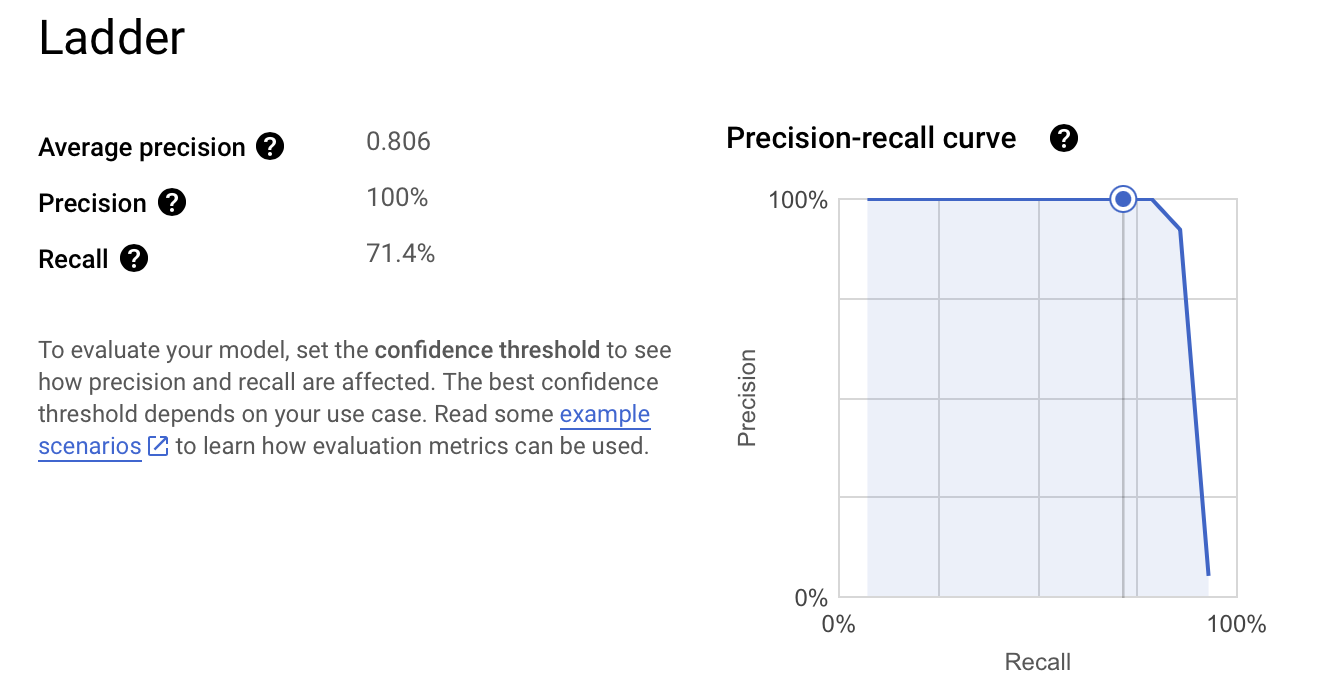
## Ladder performance
The PR curve for Ladder shows remarkably strong performance, maintaining 100% precision across most of the recall range before dropping sharply near the end. This "high plateau" pattern indicates that the model is extremely confident and accurate in its ladder predictions up to a certain recall point. 

In practice, this means when the model identifies something as a ladder, it's consistently correct, but it becomes dramatically less reliable when pushed to detect more challenging or ambiguous cases. 

The sharp drop suggests a clear distinction between the model's confident predictions and its uncertain ones, which is actually a desirable characteristic as it makes the confidence threshold choice more straightforward.

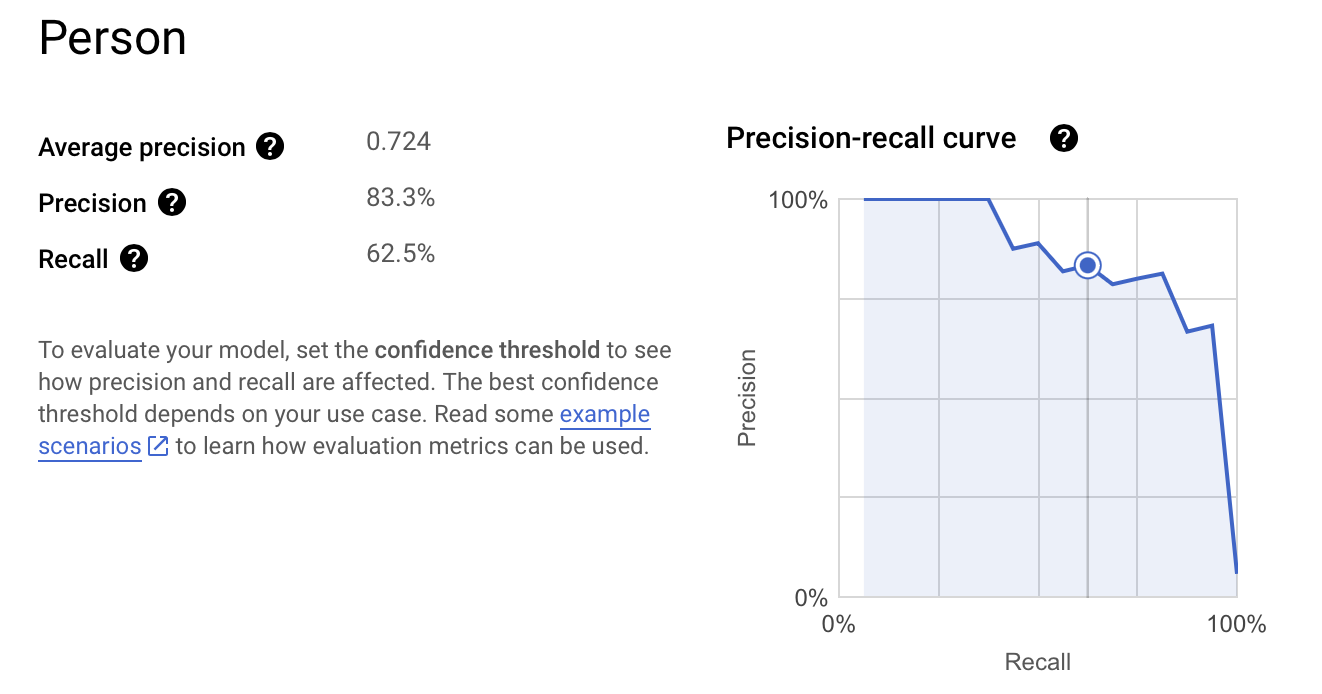
## Person performance
The PR curve for Person shows a more gradual decline in precision as recall increases. This gentle slope indicates greater uncertainty in person detection, with performance degrading more steadily as the model attempts to detect more challenging cases. 

The curve's shape suggests that person detection is inherently more challenging, likely due to the greater variability in human poses, clothing, and partial occlusions that occur in real-world scenarios.

## Why is Person detection worse than Ladder?
I would assume that ladders are iconic in the way that they have two stands and some steps to climb on. They're usually grey or have some sort of metalic shin. Whereas humans can look vastly different, some of our images that we trained our model on only include the feet or legs of the Person.

## Potential adjustments
Based on these curves, several adjustments could improve the model's practical utility. For ladder detection, the current performance is excellent, but we might consider setting a relatively high confidence threshold (around 0.7-0.8) to operate in the "plateau" region of the PR curve, ensuring extremely reliable detections while still maintaining good recall. This would be particularly appropriate in automated safety monitoring systems where false alarms could be disruptive.

The PR curves also suggest that treating ladder and person detection as separate tasks with different thresholds might be optimal. In a real-world safety monitoring system, we could implement different confidence thresholds for each class, leveraging the high-precision ladder detection while maintaining broader coverage for person detection. This dual-threshold approach would better align with the practical reality that false positives and false negatives have different costs for each class in a safety context.

### Deploy Model & Prediction

Reference: [predictions.deploy-model-api](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api)

Steps
1. Prepare your test images
2. Create an endpoint
3. Deploy your model into the endpoint
4. Perform prediction on your model
5. Undeploy your model in endpoint

Having an endpoint does not incur charges. The **deployed model** in your endpoint incurs charges so you must undeploy after prediction. In other words, once you execute step 3, complete step 4 and 5 as soon as possible to minimise your charges.

**Prepare your test images**

Prepare your test images required for online prediction. Once done, proceed on.

In [36]:
# model is from dag.run(); not empty
model

resource name: projects/689154225179/locations/us-central1/models/8350119011354148864

*Example output:*
```
<google.cloud.aiplatform.models.Model object at 0x000001F415006BB0> 
resource name: projects/636590004944/locations/us-central1/models/486659239616446464
```

## We need to select random images that have not been used to train.

In [20]:
import os
import shutil
import pandas as pd

# 1. Create test directory if it doesn't exist
test_dir = 'test'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# 2. Read annotations.csv to get list of images that are used in training
df = pd.read_csv('annotations.csv', header=None)
training_images = set()
for path in df[0]:  # Assuming first column contains image paths
    # Extract just the filename from the full GCS path
    filename = path.split('/')[-1]
    training_images.add(filename)

# 3. Get all images from people_ladder/train directory
source_dir = 'people_ladder_copy/train'
all_images = set(f for f in os.listdir(source_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg')))

# 4. Find images that are not in annotations.csv
images_for_test = all_images - training_images

# 5. Move these images to test directory
counter = 10
for image in images_for_test:
    if counter == 0:
        print(counter)
        break
    counter = counter - 1
    source_path = os.path.join(source_dir, image)
    dest_path = os.path.join(test_dir, image)
    shutil.copy2(source_path, dest_path)  # Using copy2 to preserve metadata
    print(f"Moved {image} to test directory")

print(f"\nMoved {len(images_for_test)} images to test directory")

Moved class2_144_jpg.rf.16e545e4fc79ad5c6faebdcd3ddc4013.jpg to test directory
Moved class5_163_jpg.rf.16508754d9c2580b6ed8470f08bd1b0b.jpg to test directory
Moved class5_111_jpg.rf.3b88b7766be4cb38f9edf05ab4010c56.jpg to test directory
Moved class4_114_jpg.rf.3f6c1ae37015eae8981fb620d705cd70.jpg to test directory
Moved class1_223_jpg.rf.e758c1f0448be805c1893b6256a879c3.jpg to test directory
Moved class2_097_jpg.rf.3245f0aea15dd66f4ab8b50dbb6cc16d.jpg to test directory
Moved 42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg to test directory
Moved class5_040_jpg.rf.b8e7b1686542b3bd1d72d1f58834c884.jpg to test directory
Moved safety-fail-7_jpg.rf.ae8226df44dcd37f1bde6fba1aae6886.jpg to test directory
Moved a417b55e8446fc6c4ead3ad831a5dd1b-1-_jpg.rf.72842b70cbe98634f1220cb8a4f95170.jpg to test directory
0

Moved 846 images to test directory


In [ ]:
# if model is empty (e.g. kernel died), retrieve a reference from the server 
# models = aip.Model.list()
# model = models[0]

In [37]:
display_name

'Workplace_Safety_CV'

In [43]:
# should be empty [] because there is no endpoint yet
aip.Endpoint.list()

 resource name: projects/689154225179/locations/us-central1/endpoints/1750010194558976000]

In [44]:
try:
    endpoint = aip.Endpoint.create(display_name=display_name)
except Exception as e:
    print(f"Error details: {str(e)}")
    print(f"Error type: {type(e)}")

Creating Endpoint
Create Endpoint backing LRO: projects/689154225179/locations/us-central1/endpoints/5718807366179225600/operations/4733768539670839296
Endpoint created. Resource name: projects/689154225179/locations/us-central1/endpoints/5718807366179225600
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/689154225179/locations/us-central1/endpoints/5718807366179225600')


**Create an Endpoint**

*Example output:*
<pre>
Creating Endpoint
Create Endpoint backing LRO: projects/636590004944/locations/us-central1/endpoints/304470162893963264/operations/2602331198726340608
<span style="background-color: #FFFF00">Endpoint created.</span> Resource name: projects/636590004944/locations/us-central1/endpoints/304470162893963264
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/636590004944/locations/us-central1/endpoints/304470162893963264')
</pre>

**Deploy your model into the endpoint**

Next, deploy your model for online prediction. To deploy the model, invoke the `deploy` method.

<span style="color:red">&#x26A0; Note that once you deploy your model, charges would be incurred until you undeploy your model.</span>

## Test_images()

A function to deploy a model, test multiple images, undeploy a model and save prediction results to a .json file

In [45]:
import base64
import json
import os

def get_base64(image_path):
    """Helper function to encode image to base64"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read())

def test_images(test_dir, endpoint, model):
    """
    Run predictions on all images in test directory using deployed endpoint
    
    Args:
        test_dir (str): Path to directory containing test images
        display_name (str): Display name for the endpoint
        model: The trained model object to deploy
    
    Returns:
        dict: Dictionary containing predictions for all images
    """
    # Create and deploy endpoint
    print("Creating and deploying endpoint...")
    endpoint.deploy(model)
    print("Endpoint deployed successfully")
    
    # Get all images from test directory
    image_files = [f for f in os.listdir(test_dir)
                   if f.lower().endswith(('.jpg', '.jpeg'))]
    
    # Dictionary to store all predictions
    all_predictions = {}
    
    try:
        # Process each image
        for img_filename in image_files:
            print(f"Processing {img_filename}")
            img_path = os.path.join(test_dir, img_filename)
            
            # Create instance with base64 encoded image
            instances = [{
                "content": get_base64(img_path).decode("utf-8")
            }]
            
            # Get prediction
            prediction = endpoint.predict(instances=instances)
            
            # Store prediction
            all_predictions[img_filename] = prediction
            print(f"Prediction completed for {img_filename}")
    
    finally:
        # Always undeploy endpoint, even if there's an error
        print("Undeploying endpoint...")
        endpoint.undeploy_all()
        print("Endpoint undeployed")
    
    # Save predictions to JSON file
    output_file = "predictions.json"
    with open(output_file, 'w') as f:
        json.dump(all_predictions, f, indent=4)
    print(f"Predictions saved to {output_file}")
    
    return all_predictions

In [46]:
predictions = test_images(
    test_dir="test",
    endpoint=endpoint,
    model=model
)

Creating and deploying endpoint...
Deploying Model projects/689154225179/locations/us-central1/models/8350119011354148864 to Endpoint : projects/689154225179/locations/us-central1/endpoints/5718807366179225600
Deploy Endpoint model backing LRO: projects/689154225179/locations/us-central1/endpoints/5718807366179225600/operations/580323783328399360
Endpoint model deployed. Resource name: projects/689154225179/locations/us-central1/endpoints/5718807366179225600
Endpoint deployed successfully
Processing safety-fail-7_jpg.rf.ae8226df44dcd37f1bde6fba1aae6886.jpg
Prediction completed for safety-fail-7_jpg.rf.ae8226df44dcd37f1bde6fba1aae6886.jpg
Processing class4_114_jpg.rf.3f6c1ae37015eae8981fb620d705cd70.jpg
Prediction completed for class4_114_jpg.rf.3f6c1ae37015eae8981fb620d705cd70.jpg
Processing 42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg
Prediction completed for 42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg
Processing a417b55e8446fc6c4ead3ad831a5dd1b-1-_jpg.rf.7284

In [47]:
# must be empty [] (i.e. there is no model deployed in the endpoint); inform tutor if otherwise
aip.Endpoint.list_models(endpoint)

[]

In [84]:
def draw_predictions(predictions_file, test_dir, output_dir='predictions_output', top_k=None, top_p=None):
    """
    Draw predictions on images with either top k results or confidence threshold
    
    Args:
        predictions_file (str): Path to predictions JSON file
        test_dir (str): Directory containing test images
        output_dir (str): Directory to save annotated images
        top_k (int): Number of top predictions to show (optional)
        top_p (float): Confidence threshold (0-1) for predictions to show (optional)
    """
    if top_k is None and top_p is None:
        top_k = 1  # Default to showing top 1 prediction if neither is specified
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Read predictions
    with open(predictions_file, 'r') as f:
        predictions = json.load(f)
    
    # Process each image
    for image_name, prediction in predictions.items():
        print(f"Processing {image_name}")
        
        # Read image with PIL
        img_path = os.path.join(test_dir, image_name)
        image = Image.open(img_path)
        draw = ImageDraw.Draw(image)
        
        # Get image dimensions
        width, height = image.size
        
        # Get predictions and scores
        boxes = prediction[0][0]['bboxes']
        scores = prediction[0][0]['confidences'] if 'confidences' in prediction[0][0] else None
        display_names = prediction[0][0]['displayNames'] if 'displayNames' in prediction[0][0] else None
        
        # Filter predictions based on either top_k or top_p
        if scores is not None:
            # Create list of tuples with (box, score, display_name) for easier filtering
            pred_tuples = list(zip(boxes, scores, display_names if display_names else ['Ladder'] * len(boxes)))
            
            if top_p is not None:
                # Filter by confidence threshold
                filtered_preds = [t for t in pred_tuples if t[1] >= top_p]
            else:
                # Take top k predictions (they're already sorted by confidence)
                filtered_preds = pred_tuples[:top_k]
        else:
            # If no scores available, use top_k
            filtered_preds = list(zip(boxes[:top_k], 
                                    [1.0] * min(top_k, len(boxes)),
                                    ['Ladder'] * min(top_k, len(boxes))))
        
        # Draw predictions
        for box, score, display_name in filtered_preds:
            # Convert normalized coordinates to pixel coordinates
            x1 = int(box[0] * width)
            y1 = int(box[2] * height)
            x2 = int(box[1] * width)
            y2 = int(box[3] * height)
            color = "green" if display_name == 'Ladder' else 'blue'
            
            # Draw rectangle
            draw.rectangle([(x1, y1), (x2, y2)], outline=color, width=2)
            
            # Draw label with score
            label = f"{display_name}: {score:.2f}"
            
            try:
                font = ImageFont.truetype("arial.ttf", 24)
            except:
                font = ImageFont.load_default(24)
            
            # Draw text with background
            text_bbox = draw.textbbox((x1, y1), label, font=font)
            draw.rectangle(text_bbox, fill=color)
            draw.text((x1, y1), label, fill='white', font=font)
        
        # Save annotated image
        output_path = os.path.join(output_dir, f"pred_{image_name}")
        image.save(output_path)
        print(f"Saved annotated image to {output_path}")
        print(f"Drew {len(filtered_preds)} predictions")

# Usage examples:
# By top k:
# draw_predictions('predictions.json', 'test', top_k=3)

# By confidence threshold:
# draw_predictions('predictions.json', 'test', top_p=0.5)

# If both provided, top_p takes precedence:
# draw_predictions('predictions.json', 'test', top_k=3, top_p=0.5)
draw_predictions("predictions.json", "test", top_p=0.5)

Processing safety-fail-7_jpg.rf.ae8226df44dcd37f1bde6fba1aae6886.jpg
Saved annotated image to predictions_output/pred_safety-fail-7_jpg.rf.ae8226df44dcd37f1bde6fba1aae6886.jpg
Drew 2 predictions
Processing class4_114_jpg.rf.3f6c1ae37015eae8981fb620d705cd70.jpg
Saved annotated image to predictions_output/pred_class4_114_jpg.rf.3f6c1ae37015eae8981fb620d705cd70.jpg
Drew 0 predictions
Processing 42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg
Saved annotated image to predictions_output/pred_42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg
Drew 2 predictions
Processing a417b55e8446fc6c4ead3ad831a5dd1b-1-_jpg.rf.72842b70cbe98634f1220cb8a4f95170.jpg
Saved annotated image to predictions_output/pred_a417b55e8446fc6c4ead3ad831a5dd1b-1-_jpg.rf.72842b70cbe98634f1220cb8a4f95170.jpg
Drew 1 predictions
Processing class2_144_jpg.rf.16e545e4fc79ad5c6faebdcd3ddc4013.jpg
Saved annotated image to predictions_output/pred_class2_144_jpg.rf.16e545e4fc79ad5c6faebdcd3ddc4013.jpg
Drew 2 predict

> &#128161; **Progress Check #3** - Vertex AI console 

## Analysis
Now that we have our images with bounding boxes saved, we can proceed to analyse them. As recommended by Dr Brandon, I will be picking out 3 of the most interesting images to view.

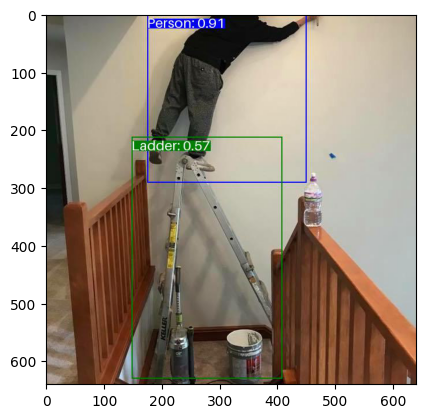

In [85]:
import matplotlib.pyplot as plt

plt.imshow(Image.open("predictions_output/pred_42gb2egeclrz_jpg.rf.6151d7f97c827f74b8ef2508d25465d0.jpg"))

we see high-confidence person detection (0.91) where the subject is clearly visible in a concerning position - reaching over what appears to be a stair railing. The ladder detection (0.57) shows relatively low confidence despite clear visibility, which might be due to the unusual setup against the railing. This scenario represents exactly the kind of safety violation we'd want to detect, and the model has successfully identified both components, though the ladder confidence could be stronger.

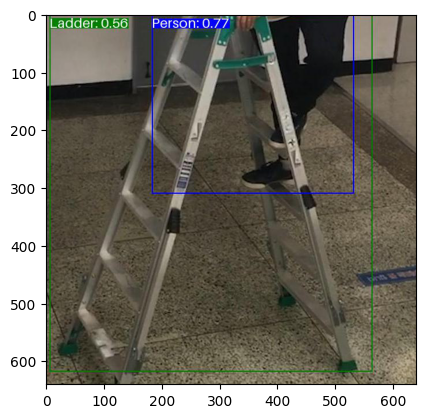

In [86]:
plt.imshow(Image.open("predictions_output/pred_class5_111_jpg.rf.3b88b7766be4cb38f9edf05ab4010c56.jpg"))

image shows moderate confidence scores for both ladder (0.56) and person (0.77). Here, the ladder is properly set up as an A-frame, and the person is partially in frame. The moderate confidence levels are interesting - despite this being a more "standard" ladder setup, we're not seeing higher confidence in the ladder detection, even though 90-99% of the ladders given to train are A-frame ladders

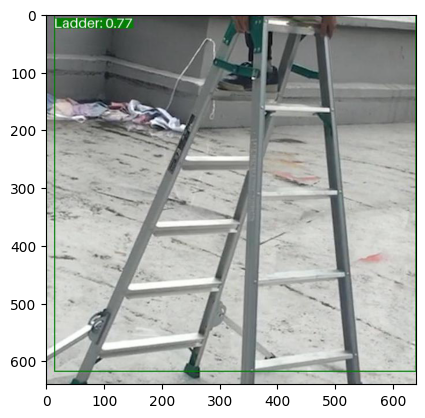

In [87]:
plt.imshow(Image.open("predictions_output/pred_class2_097_jpg.rf.3245f0aea15dd66f4ab8b50dbb6cc16d.jpg"))

critical failure in person detection - there's a visible foot in the frame that the model completely missed, while assigning high confidence (0.77) to the ladder. This is a serious concern for a safety monitoring system, as partial person detection is crucial for identifying potential accidents or unsafe situations. The higher confidence in ladder detection when compared to the previous images seems to be influenced by the ladder's clear, unobstructed view, but missing the person presence entirely points to a significant limitation.

Then again, I believe that with a wider CCTV view, the model should be able to identify the partially obstructed person.

## Reflection

Expanding use case of model:
- Confidence metadata during annotation process
- Additional labels or classification models to detect safe and unsafe labels
- Flag scenarios when ladder confidence drops and person exist. Could indicate usage or mayble unsafe patterns

My learnings:
- General accuracy and precision isn't everything
- Build undeployment as part of testing pipeline to minimize cloud usage cost
- Separate deployment predictions and the drawing of bounding boxes
- Focus on getting the cleaning and processing right for a easier time